In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import os
import matplotlib.pyplot as plt

2025-04-20 20:56:13.714381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745182573.737226     364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745182573.744370     364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Problem description
Here we have a normal set of images, where we need to create monet style replica of these images. Goal is to build GAN architecture model to create monet style images. GAN has generator & discriminator. Generator will be generating images & try to fool discriminator with fake images, where as the goal of discriminator is to find the real ones & fake ones. We have 7k+ images in the photo_jpg folder, which we will be using to create monet style images.

Input files
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format

Finally, submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID)

# EDA
I try loading the files to the monet & photo datasets. I see that each of the images were in 256x256x3 dimension. I tried printing the real & monet images below & see that the monet images doesn't have sharper tone & they look more softer than the real images, looking like the multiple average of 4 pixels filter from the real images would make it closer to the monet images style.

In [3]:
GCS_PATH = '/kaggle/input/gan-getting-started'

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

def image_decoder(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) * 2 / 255) - 1  # Normalize to [-1, 1]
    return tf.reshape(image, [256, 256, 3]) # given shape is 256 x 256, so this would be reduncant mostly.

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    return image_decoder(example['image'])

def load_dataset_from_filenames(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    return dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)

monet_ds = load_dataset_from_filenames(MONET_FILENAMES).batch(1)
photo_ds = load_dataset_from_filenames(PHOTO_FILENAMES).batch(1)

I0000 00:00:1745182576.775409     364 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
MONET_FILENAMES

['/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec',
 '/kaggle/input/gan-getting-started/monet_tfrec/monet16-60.tfrec',
 '/kaggle/input/gan-getting-started/monet_tfrec/monet08-60.tfrec',
 '/kaggle/input/gan-getting-started/monet_tfrec/monet04-60.tfrec',
 '/kaggle/input/gan-getting-started/monet_tfrec/monet00-60.tfrec']

# Visualizations
I have printed couple of real & monet style images to compare.

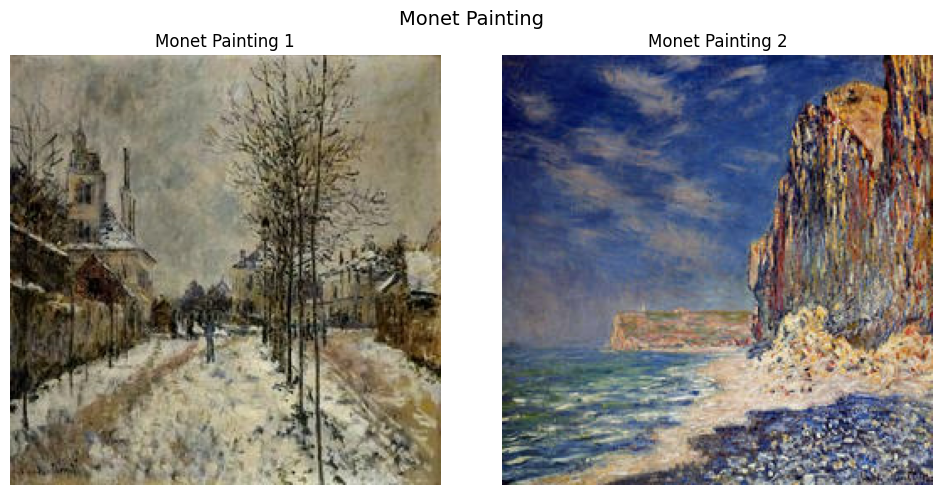

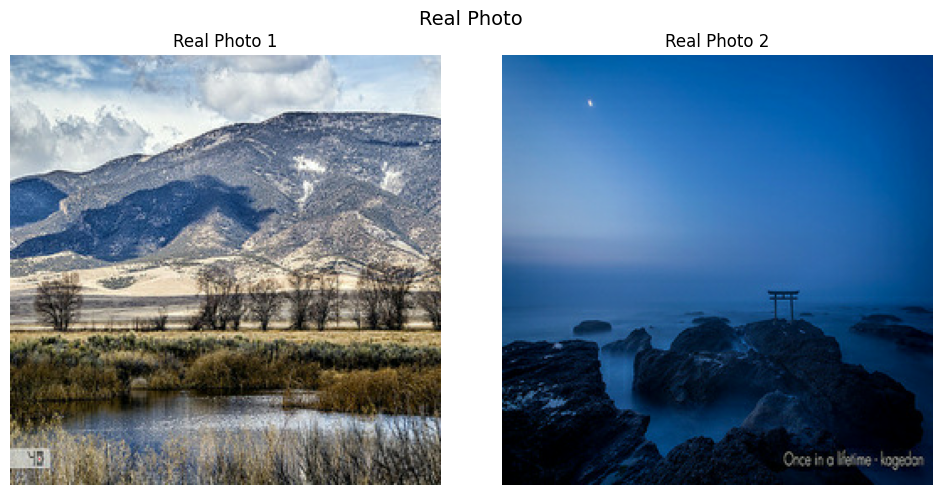

In [5]:
def denormalize_image(image):
    # Convert from [-1, 1] to [0, 1] for Matplotlib
    image = (image + 1) / 2 
    return np.clip(image, 0, 1) 

# Function to display sample images from a dataset
def display_sample_images(dataset, title, num_images=2):
    plt.figure(figsize=(10, 5))
    plt.suptitle(title, fontsize=14)
    
    # Extract num_images from the dataset
    for i, image in enumerate(dataset.take(num_images)):
        # Convert tensor to numpy and remove batch dimension
        image = image.numpy()[0]  # Shape: [1, 256, 256, 3] -> [256, 256, 3]
        image = denormalize_image(image)
        
        # Plot image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'{title} {i+1}')
    
    plt.tight_layout()
    plt.show()

# Display 2 images from each dataset
display_sample_images(monet_ds, "Monet Painting", num_images=2)
display_sample_images(photo_ds, "Real Photo", num_images=2)

# Plan of analysis
I'm going to normalize the images to -1 to 1, making it cleaner dataset. I'll be using GAN architecture to monet style images. There are 2 popular GANs for this purpose, CycleGAN & StyleGAN. CycleGAN will be lightweighted, so would be using this for the project. 

# Model architecture

Generator: I'll use build_generator function (U-Net-like with downsampling, upsampling, and skip connections). I'll be adding multiple layers of downsampling & Upsampling with batchnormalization & using LeakyReLU making it more stable than ReLU for this purpose.

Discriminator: It's a critical component to identify the real images among fake ones which are generated by the generator.

For generator, in this case we have 5 layers of downsampling to images of size 8x8 & 4 layers of upsampling & an additional upsampling output layer with 3 filters to create the final image size of 256x256x3, which is same as our input images.

For discriminator, we have 5 downsampling layers along with batch normalizing & leakyReLU activation function & an additional output layer.

In [6]:
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    # Downsampling layers
    down_stack = [
        # 256x256x3 -> 128x128x64
        [layers.Conv2D(64, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU()],
        # 128x128x64 -> 64x64x128
        [layers.Conv2D(128, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU()],
        # 64x64x128 -> 32x32x256
        [layers.Conv2D(256, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU()],
        # 32x32x256 -> 16x16x512
        [layers.Conv2D(512, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU()],
        # 16x16x512 -> 8x8x512
        [layers.Conv2D(512, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU()]
    ]
    
    # Upsampling layers
    up_stack = [
        # 8x8x512 -> 16x16x512
        [layers.Conv2DTranspose(512, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU(),
         layers.Dropout(0.5)],
        # 16x16x512 -> 32x32x256
        [layers.Conv2DTranspose(256, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU(),
         layers.Dropout(0.5)],
        # 32x32x256 -> 64x64x128
        [layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU(),
         layers.Dropout(0.5)],
        # 64x64x128 -> 128x128x64
        [layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
         layers.BatchNormalization(momentum=0.8),
         layers.LeakyReLU(),
         layers.Dropout(0.5)]
    ]
    
    # Skip connections storage
    skips = []
    x = inputs
    
    # Downsampling and store skip connections
    for block in down_stack:
        for layer in block:
            x = layer(x)
        skips.append(x)  # Store after each block (after ReLU)
    
    # Exclude the last downsampling output (16x16x512)
    skips = skips[:-1]
    
    # Reverse skips for upsampling
    skips = reversed(skips)
    
    # Upsampling with skip connections
    for block, skip in zip(up_stack, skips):
        for layer in block:
            x = layer(x)
        x = layers.Concatenate()([x, skip])  # Add skip connection
    
    # The final Output layer: 128x128x128 -> 256x256x3
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    
    return Model(inputs=inputs, outputs=outputs)

monet_generator = build_generator()

In [7]:
monet_generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          3,136 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,664 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 512)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 512)      │      4,194,816 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 8, 512)      │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 512)      │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      4,194,816 │ leaky_re_lu_4[0][0]    │
│ (Conv2DTranspose)    

 Total params: 16,667,523 (63.58 MB)

 Trainable params: 16,662,659 (63.56 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [8]:
def build_discriminator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    # Downsampling layers
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(inputs)  # 256x256x3 -> 128x128x64
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)  # 128x128x64 -> 64x64x128
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)  # 64x64x128 -> 32x32x256
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)  # 32x32x256 -> 32x32x512
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)  # 32x32x512 -> 32x32x512
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    
    return Model(inputs=inputs, outputs=outputs)

monet_discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [9]:
monet_discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 512)         │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,965,185 (26.57 MB)

 Trainable params: 6,962,369 (26.56 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [10]:
photo_generator = build_generator()
photo_discriminator = build_discriminator()

In [12]:
# Use Binary Cross Entropy for adversarial loss
# from_logits=True because the discriminator output is raw logits (no sigmoid)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)       # Target is 1 for real images
    generated_loss = bce(tf.zeros_like(generated), generated) # Target is 0 for fake images
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # Scale down the loss (common practice)

def generator_loss(generated):
    # The generator wants the discriminator to think the fake image is real (target is 1)
    return bce(tf.ones_like(generated), generated)

# Use Mean Absolute Error (L1 Loss) for cycle and identity losses
mae = tf.keras.losses.MeanAbsoluteError()
LAMBDA_CYCLE = 10.0  # Weight for cycle consistency loss
LAMBDA_ID = 0.5 * LAMBDA_CYCLE # Weight for identity loss (often 0.5 * lambda_cycle)

def calc_cycle_loss(real_image, cycled_image):
    loss = mae(real_image, cycled_image)
    return LAMBDA_CYCLE * loss

def calc_identity_loss(real_image, same_image):
    loss = mae(real_image, same_image)
    return LAMBDA_ID * loss

Loss functions defined.


In [56]:
# Define optimizers (Adam is commonly used for CycleGAN)
generator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # For monet_generator
generator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # For photo_generator 

discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # For monet_discriminator 
discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5) # For photo_discriminator

In [57]:
@tf.function
def train_step(real_photo, real_monet):
    # persistent=True allows accessing gradients from the tape multiple times
    with tf.GradientTape(persistent=True) as tape:
        # --- Generator G (Photo -> Monet) and F (Monet -> Photo) ---
        fake_monet = monet_generator(real_photo, training=True)
        cycled_photo = photo_generator(fake_monet, training=True)

        fake_photo = photo_generator(real_monet, training=True)
        cycled_monet = monet_generator(fake_photo, training=True)

        # Identity mapping (optional but recommended)
        same_monet = monet_generator(real_monet, training=True)
        same_photo = photo_generator(real_photo, training=True)

        # --- Discriminator Dx (Monet) and Dy (Photo) ---
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)

        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)

        # --- Calculate Losses ---
        # Generator Adversarial Loss
        gen_m_loss = generator_loss(disc_fake_monet) # G wants Dx to think fake_monet is real
        gen_p_loss = generator_loss(disc_fake_photo) # F wants Dy to think fake_photo is real

        # Cycle Consistency Loss
        total_cycle_loss = calc_cycle_loss(real_photo, cycled_photo) + calc_cycle_loss(real_monet, cycled_monet)

        # Total Generator Loss (adversarial + cycle + identity)
        total_gen_m_loss = gen_m_loss + total_cycle_loss + calc_identity_loss(real_monet, same_monet)
        total_gen_p_loss = gen_p_loss + total_cycle_loss + calc_identity_loss(real_photo, same_photo)

        # Discriminator Loss
        disc_m_loss = discriminator_loss(disc_real_monet, disc_fake_monet) # Dx loss
        disc_p_loss = discriminator_loss(disc_real_photo, disc_fake_photo) # Dy loss

    # --- Calculate Gradients ---
    # Generator gradients
    generator_m_gradients = tape.gradient(total_gen_m_loss, monet_generator.trainable_variables)
    generator_p_gradients = tape.gradient(total_gen_p_loss, photo_generator.trainable_variables)

    # Discriminator gradients
    discriminator_m_gradients = tape.gradient(disc_m_loss, monet_discriminator.trainable_variables)
    discriminator_p_gradients = tape.gradient(disc_p_loss, photo_discriminator.trainable_variables)

    # --- Apply Gradients ---
    generator_m_optimizer.apply_gradients(zip(generator_m_gradients, monet_generator.trainable_variables))
    generator_p_optimizer.apply_gradients(zip(generator_p_gradients, photo_generator.trainable_variables))

    discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients, monet_discriminator.trainable_variables))
    discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients, photo_discriminator.trainable_variables))

    return {
        "gen_m_loss": total_gen_m_loss,
        "gen_p_loss": total_gen_p_loss,
        "disc_m_loss": disc_m_loss,
        "disc_p_loss": disc_p_loss,
        "cycle_loss": total_cycle_loss,
    }

Starting Training Loop...
Epoch 1/10


E0000 00:00:1745187029.443286     364 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_1_2/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


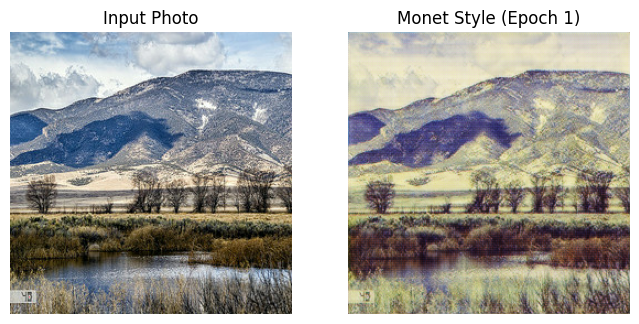

Time taken for epoch 1 is 94.07 sec

  Losses: Gen_G=7.6227, Gen_F=5.2331, Disc_X=0.5285, Disc_Y=0.7769, Cycle_loss=3.5095
Epoch 2/10



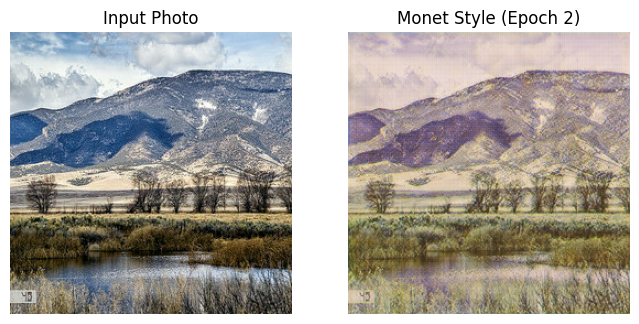

Time taken for epoch 2 is 54.25 sec

  Losses: Gen_G=5.8247, Gen_F=4.6568, Disc_X=1.0439, Disc_Y=0.4394, Cycle_loss=3.1241
Epoch 3/10



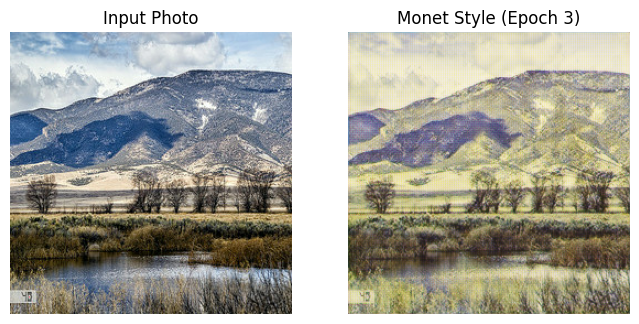

Time taken for epoch 3 is 54.22 sec

  Losses: Gen_G=6.9387, Gen_F=6.5836, Disc_X=0.5944, Disc_Y=0.3682, Cycle_loss=3.8563
Epoch 4/10



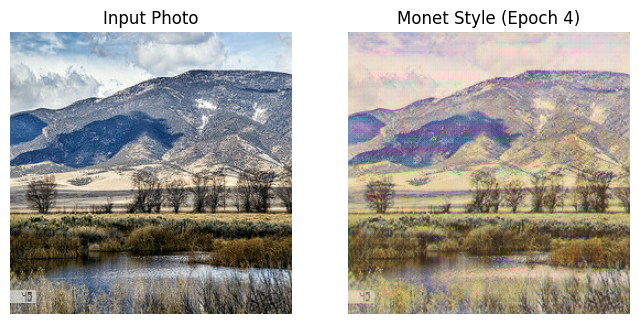

Time taken for epoch 4 is 54.22 sec

  Losses: Gen_G=6.4922, Gen_F=6.0230, Disc_X=0.5705, Disc_Y=0.6236, Cycle_loss=3.2576
Epoch 5/10



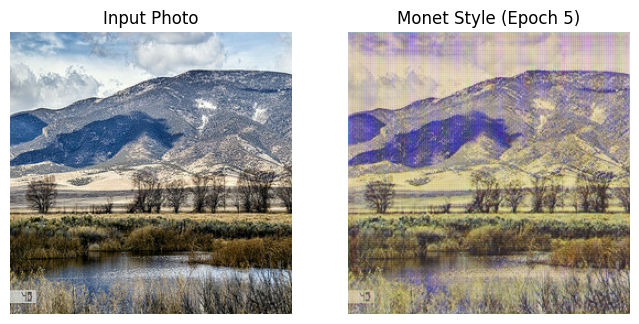

Time taken for epoch 5 is 54.21 sec

  Losses: Gen_G=6.6520, Gen_F=5.9799, Disc_X=0.3613, Disc_Y=0.5294, Cycle_loss=3.1446
Epoch 6/10



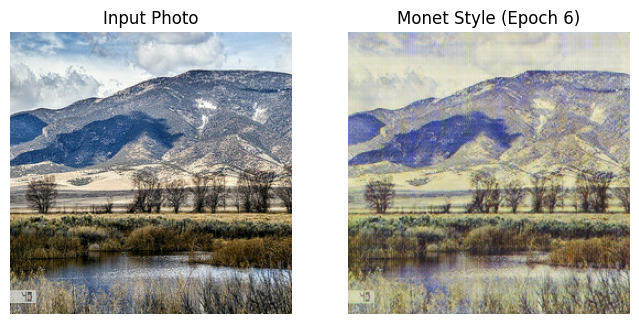

Time taken for epoch 6 is 54.21 sec

  Losses: Gen_G=8.0483, Gen_F=4.8179, Disc_X=0.1057, Disc_Y=0.4503, Cycle_loss=3.3786
Epoch 7/10



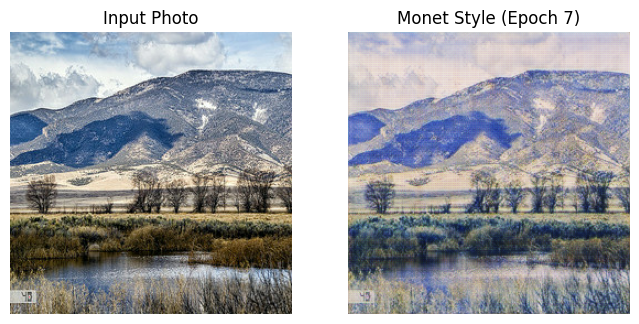

Time taken for epoch 7 is 54.23 sec

  Losses: Gen_G=7.2404, Gen_F=6.5298, Disc_X=0.2164, Disc_Y=0.2436, Cycle_loss=3.8895
Epoch 8/10



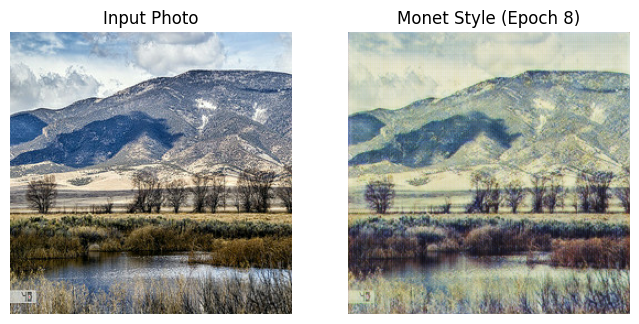

Time taken for epoch 8 is 54.23 sec

  Losses: Gen_G=7.2798, Gen_F=5.9521, Disc_X=0.4376, Disc_Y=0.2033, Cycle_loss=3.7291
Epoch 9/10



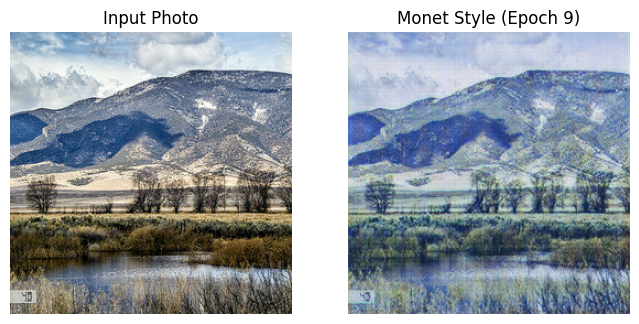

Time taken for epoch 9 is 54.22 sec

  Losses: Gen_G=8.4053, Gen_F=7.1528, Disc_X=0.0635, Disc_Y=0.2380, Cycle_loss=4.0380
Epoch 10/10



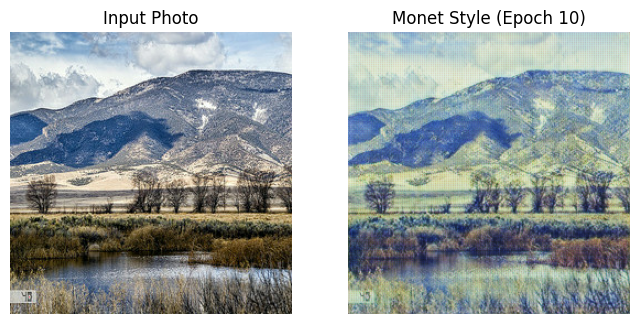

Time taken for epoch 10 is 54.25 sec

  Losses: Gen_G=7.7455, Gen_F=6.7250, Disc_X=0.1467, Disc_Y=0.3592, Cycle_loss=3.4235
Training Finished.


In [58]:
import time

EPOCHS = 10
gen_m_losses = []
gen_p_losses = []
disc_m_losses = []
disc_p_losses = []
cycle_losses = []

def generate_and_save_images(model, epoch, test_input, save_path):
    # Make sure the input is a batch
    if test_input.shape.ndims == 3:
        test_input = tf.expand_dims(test_input, 0) # Add batch dimension if missing

    prediction = model(test_input, training=False) # Get prediction in [-1, 1] range

    # Denormalize for display/saving
    display_input = denormalize_image(test_input[0]) # Use [0] to get the single image from batch
    display_prediction = denormalize_image(prediction[0]) # Use [0] to get the single image from batch

    # --- Save the side-by-side comparison 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title('Input Photo')
    plt.imshow(display_input)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title(f'Monet Style (Epoch {epoch+1})')
    plt.imshow(display_prediction)
    plt.axis('off')
    comparison_filename = f'{save_path}/comparison_epoch_{epoch+1:04d}.png'
    plt.savefig(comparison_filename)
    plt.show() # Usually commented out in Kaggle notebooks
    plt.close()

# Get a sample photo to monitor progress
sample_photo = next(iter(photo_ds.take(1))) # Take one batch (size 1)

# Create directory for saving sample images
import os
save_dir = './training_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

print("Starting Training Loop...")
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # Use zip to iterate through both datasets simultaneously
    for image_photo, image_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
        losses = train_step(image_photo, image_monet)

    # Generate and save a sample image after each epoch
    print() # Newline after dots
    generate_and_save_images(monet_generator, epoch, sample_photo, save_dir)

    gen_m_losses.append(losses['gen_m_loss'].numpy())
    gen_p_losses.append(losses['gen_p_loss'].numpy())
    disc_m_losses.append(losses['disc_m_loss'].numpy())
    disc_p_losses.append(losses['disc_p_loss'].numpy())
    cycle_losses.append(losses['cycle_loss'].numpy())
    print (f'Time taken for epoch {epoch + 1} is {time.time()-start:.2f} sec\n')
    # Optional: Print loss values from the last step
    print(f"  Losses: Gen_G={losses['gen_m_loss']:.4f}, Gen_F={losses['gen_p_loss']:.4f}, Disc_X={losses['disc_m_loss']:.4f}, Disc_Y={losses['disc_p_loss']:.4f}, Cycle_loss={losses['cycle_loss']:.4f}")

print("Training Finished.")

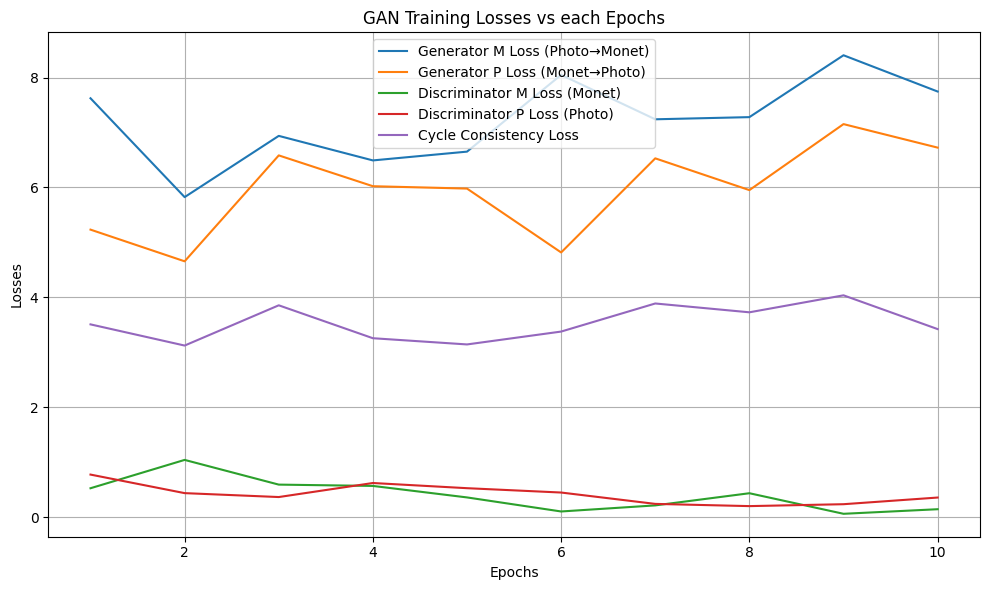

In [60]:
epochs = range(1, 11)

plt.figure(figsize=(10, 6))

plt.plot(epochs, gen_m_losses, label='Generator M Loss (Photo→Monet)')
plt.plot(epochs, gen_p_losses, label='Generator P Loss (Monet→Photo)')
plt.plot(epochs, disc_m_losses, label='Discriminator M Loss (Monet)')
plt.plot(epochs, disc_p_losses, label='Discriminator P Loss (Photo)')
plt.plot(epochs, cycle_losses, label='Cycle Consistency Loss')

plt.title("GAN Training Losses vs each Epochs")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Results & analysis:
With CycleGAN model I'm able to translate real-world photographs into the artistic style of Claude Monet paintings. Initially used few layers in downsampling & upsampling & later added more layer, have seen better improvement of the results with the more layers. I didn't see much of improvement in losses with epochs above, only discriminatory losses were consistent. 

# Conclusion & takeaways:
Could experiment with more epochs to see the better performance & add more layers to have improved prediction & can change the activation function to ReLU or some other to see how the model is performing

In [ ]:
os.makedirs('../images', exist_ok=True)
for i, img in enumerate(photo_ds):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    plt.imsave(f'../images/image_{i:04d}.jpg', prediction)
import shutil
shutil.make_archive('/kaggle/working/images', 'zip', '../images')